- **Created:** by [Danny Mitchell](https://www.mrc-cbu.cam.ac.uk/people/Daniel.Mitchell) with very minor edits by [Rik Henson](https://www.mrc-cbu.cam.ac.uk/people/rik.henson/)
- **Date:** September 2024
- **conda environment**: This uses the [mri environment](https://github.com/RikHenson/PythonNeuroimagingCourse/blob/main/mri_environment.yml)

# Multi-voxel Classification Analyses (MVPA): simulations

Much of this tutorial is based on, or inspired by, the longer fMRI-pattern-analysis course developed by Lukas Snoek at the University of Amsterdam: https://lukas-snoek.com/NI-edu/index.html.

## 0. Getting Ready

As usual, we have to **import** a bunch of packages. The main new one is `sklearn` of scikit-learn, which has a very useful website: [https://scikit-learn.org/stable](https://scikit-learn.org/stable)

In [15]:
import numpy                    # This lets python process matrices, like Matlab
import matplotlib.pyplot as plt # This lets python plot graphs like Matlab

import sklearn 
from sklearn import preprocessing   # includes LabelEncoder, OneHotEncoder, StandardScaler...
from sklearn import linear_model    # includes LogisticRegression, RidgeClassifier...
from sklearn import inspection      # includes DecisionBoundaryDisplay


In [ ]:
import nilearn as nil           # Many useful functions for MRI, including...
from nilearn import image       # to load (load_img), resample (resample_to_img), manipulate (math_img) fMRI data, etc.
from nilearn import datasets    # includes e.g. fetch_atlas_harvard_oxford
from nilearn import masking
from nilearn import input_data  # includes NiftiMasker, NiftiLabelsMasker
from nilearn import plotting    # includes plot_roi, plot_stat_map, view_img_on_surf, etc.
from nilearn import decoding    # includes Searchlight

# scikit-learn is the major library for machine learning in Python:

from sklearn import model_selection # includes StratifiedKFold, LeaveOneGroupOut, etc....
from sklearn import svm             # includes SVC, NuSVC & LinearSCV...
from sklearn import discriminant_analysis # includes LinearDiscriminantAnalysis
from sklearn import metrics         # includes accuray, balanced accuracy, roc_auc_score, etc....
from sklearn import pipeline        # includes make_pipeline

# scipy? # provides basic statistic functions, e.g. t-tests, and allows import of Matlab files
# glob? # to search filenames with wildcards

%matplotlib inline

\
First, we'll **set the seed to numpy's random number generator**, to get the same sequence of random values every time:

In [2]:
numpy.random.seed(3) # (if it's not desireable to set a global seed, a seeded RandomState can be passed to the relevant functions)


## 1. Examples using simulated data, with a true effect

### 1.1 Define data matrix and labels:

Now, we'll **simulate some data from a single participant**.
Let's define **two conditions**, e.g. faces and scrambled faces.
We'll simulate **four runs**, with **three repeats** of each condition per run. We'll assume that each repeat has been separately estimated from a GLM (see previous notebooks), so we would have 4 x 3 x 2 = 24 activation patterns. The values in each pattern could be beta coefficients, contrasts, or t statistics.
For now, **we'll just consider two voxels** from each activation map, to make things easier to visualise.

In [3]:
nruns = 4     # number of runs 
n_per_run = 3 # number of repetitions per run
mu1 = numpy.array([2.0, -0.5]) # mean activation for condition 1 (1st voxel activated; 2nd voxel deactivated)
mu2 = numpy.array([-0.5, 2.0]) # mean activation for condition 2 (opposite pattern)
voxel_covariance = numpy.diag([0.0, 3.0])+1 # independent noise per voxel; 2nd voxel is noisier; shared noise is positively correlated
print("Noise covariance matrix: \n", voxel_covariance )

data_per_run = []   # list of pattern matrices (one per run)
labels_per_run = [] # list of label vectors (one per run)
for r in numpy.arange(nruns):  # loop over runs
    a1 = numpy.random.multivariate_normal(mu1, voxel_covariance, size=n_per_run) # activations for condition 1
    a2 = numpy.random.multivariate_normal(mu2, voxel_covariance, size=n_per_run) # activations for condition 2 (different mean, same noise covarience)
    data_matrix = numpy.concatenate((a1, a2), axis=0) # stack condition 1 (n rows of observations) then condition 2 (n more observations)
    # add some extra noise that is similar across conditions and voxels, but whose mean and variance increases across runs:
    data_matrix = data_matrix + numpy.random.normal( r*10, r, size=(2*n_per_run,2))
    
    label_vector = n_per_run*["faces"] + n_per_run*["scrambled"]
    
    data_per_run.append( data_matrix )  # append this run's data to list
    labels_per_run.append( label_vector ) 
    
print("\nData matrix for first run:\n", data_per_run[0])
print("\nLabel vector for each run:\n", labels_per_run[0])

Noise covariance matrix: 
 [[1. 1.]
 [1. 4.]]

Data matrix for one run:
 [[ 3.42399636  2.94535756]
 [ 0.56875471  0.14248595]
 [ 1.54974783 -0.96486031]
 [-1.05081722  1.98744775]
 [-0.90771828  2.02847969]
 [-0.58280322 -0.82247891]]

Label vector for one run:
 ['faces', 'faces', 'faces', 'scrambled', 'scrambled', 'scrambled']


We now have everything we need for a decoding analysis. However, functions often require data to be represented numerically, so we will also **convert the labels to integers**. This can be done in various ways, but here we'll use the the `LabelEncoder` class from scikit-learn:

In [4]:
lab_enc = sklearn.preprocessing.LabelEncoder() # this initialises the LabelEncoder object
labels_per_run_int = []
for r in numpy.arange(nruns):
    labels_per_run_int.append( lab_enc.fit_transform(labels_per_run[r]) )
    
print("Integer labels for all runs:\n", labels_per_run_int)

Integer labels for all runs:
 [array([0, 0, 0, 1, 1, 1]), array([0, 0, 0, 1, 1, 1]), array([0, 0, 0, 1, 1, 1]), array([0, 0, 0, 1, 1, 1])]


Notice that we first initialised a `LableEncoder` object, and then called its `.fit_transform` method. Many objects also have `.fit` and `.transform` methods that can be called separately. This procedure is similar for most objects in scikit-learn.

Before doing anything else, let's **plot the data:**

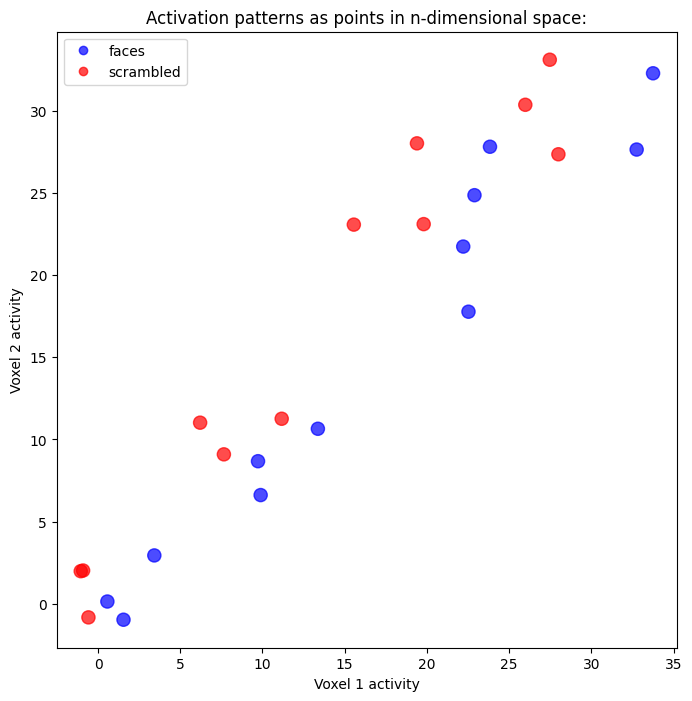

In [6]:
concatenated_runs  = numpy.concatenate(data_per_run,axis=0)       # concatenate data across runs
concatenated_labels= numpy.concatenate(labels_per_run_int,axis=0) # concatenate labels across runs

fig=plt.figure(figsize=(8,8));  # create a matplotlib figure
plt.title('Activation patterns as points in n-dimensional space:');
scatter = plt.scatter(concatenated_runs[:,[0]], concatenated_runs[:,[1]], 
                      s= 90, alpha=0.7, c=concatenated_labels, cmap='bwr');
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels_per_run[0])); # "set" returns unique values
plt.xlabel('Voxel 1 activity');
plt.ylabel('Voxel 2 activity');
plt.rcParams.update({'font.size': 18});
plt.axis('equal');

You can imagine that, by drawing a diagonal line y=x, one could separate most of the red dots from most of the blue dots. This would be a decision boundary that a classifier needs to learn.

### 1.2 Initial classification, without cross-validation:

At this stage, it is common to **standardise each feature**, e.g. by rescaling into the range [0 1], or by z-scoring (subtracting mean and dividing by standard deviation across samples). For many classifiers, standardizing each feature across all samples should not change the classification accuracy (e.g., such transformations would not change the decision boundary in the figure above). However, putting each feature on the scame scale can help parameters to be estimated efficiently, and may be necessary for some models to converge. 

Here we will z-score each feature across all samples of all runs. Note that one could rescale features for each class separately - though by doing this, you would remove any mean difference between classes, and the mean could be important for distinguishing the classes. Nonetheless, you could still be able to classify based on different covariance between voxels (see next notebook where this is done). Note that one could also rescale rescale features for each run separately, which might help remove differences in mean/scaling that you do not care about (assuming each class represented equally often within each run).

Again, we do this scaling by initialising a scikit-learn object and calling its `fit_transform` method:

In [7]:
scaler           = sklearn.preprocessing.StandardScaler()
concatenated_runs= scaler.fit_transform(concatenated_runs)

Let's plot the data again to confirm:

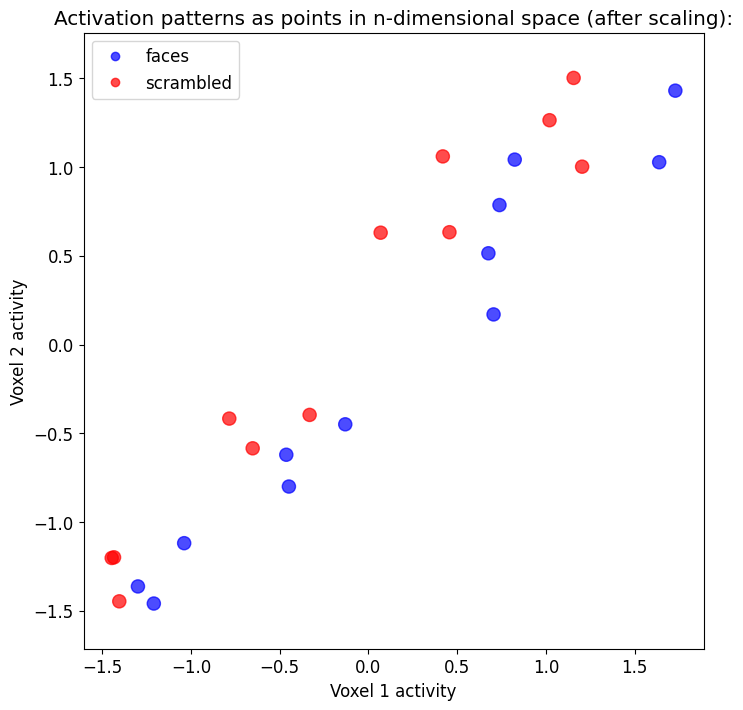

In [9]:
fig=plt.figure(figsize=(8,8));  # create a matplotlib figure
plt.rcParams.update({'font.size': 12});
plt.title('Activation patterns as points in n-dimensional space (after scaling):');
scatter = plt.scatter(concatenated_runs[:,[0]], concatenated_runs[:,[1]], 
                      s= 90, alpha=0.7, c=concatenated_labels, cmap='bwr');
plt.legend(handles=scatter.legend_elements()[0], labels=set(labels_per_run[0])); # "set" returns unique values
plt.xlabel('Voxel 1 activity');
plt.ylabel('Voxel 2 activity');
plt.rcParams.update({'font.size': 18});
plt.axis('equal');

Now we can proceed to classification. We'll start with a logistic regression classifier, which we'll initialise to a variable `LR`. Note that there are lots of different types of classifier, the pros and cons of which are beyond the present remit, though see for example: [https://medium.com/analytics-vidhya/pros-and-cons-of-popular-supervised-learning-algorithms-d5b3b75d9218](https://medium.com/analytics-vidhya/pros-and-cons-of-popular-supervised-learning-algorithms-d5b3b75d9218).

Each **classifier needs to be "trained" or "fit" using "training data" and corresponding labels.** This uses the training data to optimise the parameters of the model, to best match the labels to some function (often a linear combination) of the features.

In scikit-learn, this uses the `.fit` method of the classifier, giving the patterns matrix and labels as inputs. To start with, we'll train the classfier using all the data, concatenated across runs:

In [12]:
LR = sklearn.linear_model.LogisticRegression(solver='lbfgs') # there are more options that could be set here; we won't worry about them
LR.fit(concatenated_runs, concatenated_labels)

LogisticRegression()

The **estimated (fitted) coefficients are now stored in the classifier object**. Notice that for this linear classifier we have one coefficient per feature (voxel):

In [13]:
print("Coefficients:\n", LR.coef_)

Coefficients:
 [[-1.02966063  0.95852577]]


\
We can also plot the decision boundary:

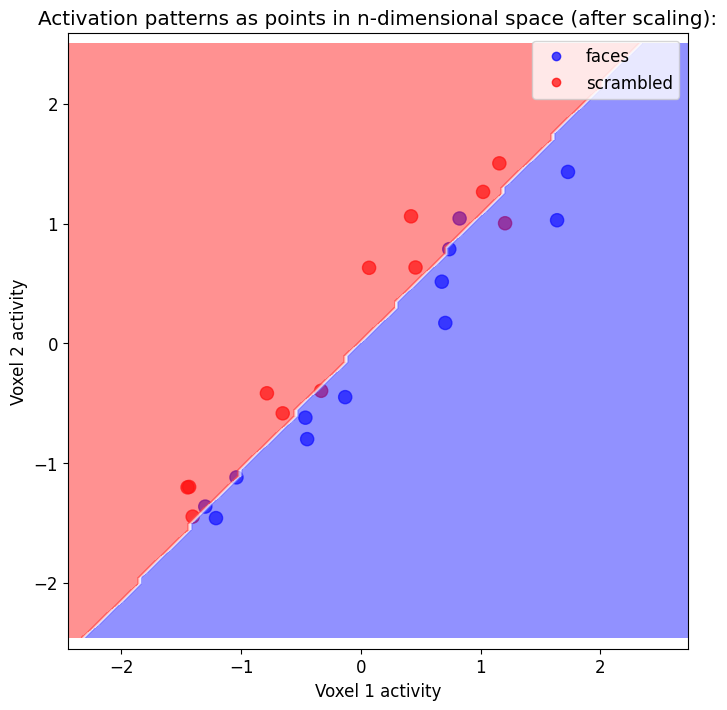

In [16]:
sklearn.inspection.DecisionBoundaryDisplay.from_estimator(LR, concatenated_runs, alpha=0.5, ax=fig.axes[0], cmap='bwr', response_method='predict');
fig

The next step is to **"test" the model by giving it some patterns and "predicting" their labels**. For now, we'll give it the same data we used to train the model: 

In [17]:
predicted_labels = LR.predict(concatenated_runs)
print("Predictions for all samples:\n", predicted_labels)

Predictions for all samples:
 [0 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1]


How accurate are these predictions? We can **"evaluate" the predictions by comparing them with the true values. The quality of the predictions is summarised as a "performance", "score" or "metric"**. If we had continuous predictions (a regression model), we might correlate them with the true values. Here we have categorical predictions (a classification model), which we can compare with the true values in various ways...

### 1.3 Measures of Accuracy

The **simplest score, called "accuracy," is just the proportion of all predictions that are correct**, calculation of which is easy:

In [31]:
print("Accuracy = " + str(numpy.mean(concatenated_labels==predicted_labels)))

# Scikit-learn also has a function to do this:
# accuracy = sklearn.metrics.accuracy_score(concatenated_labels, predicted_labels)
# print("Accuracy = " + str(accuracy))

Accuracy = 0.8333333333333334


Actually scikit-learn has **many metrics to choose from.** The only thing to recommend accuracy as a metric is its simplicity. Otherwise, it is relatively insensitive (because binary guesses discard information about the confidence of a particular prediction) and can be misleading if classes are unbalanced (more about that later).

One metric that incorporates the confidence of each prediction, and can handle unbalanced classes, is the "**Area Under the Receiver Operating Characteristic curve**" (AUROC, or just AUC). We can use a function from scikit-learn to calculate this, but instead of vectors of true and predicted labels, it generally needs matrices of true and predicted probabilities per class. (In this binary case, we could give it the vector labels and the probabilities for the class with the largest label, but this syntax doesn't generalise to more than two classes).

Matrices of true class probabilities can be constructed from the true labels using scikit-learn's `one-hot encoder` function:

In [27]:
ohe = sklearn.preprocessing.OneHotEncoder(sparse_output=False)  # we don't want a "sparse" output
true_probabilities = ohe.fit_transform(concatenated_labels.reshape(-1,1)) # the reshape is needed because the function expects a 2D input
print("True probabilities per class, for first 5 patterns:\n", true_probabilities[0:5])

True probabilities per class, for first 5 patterns:
 [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


Matrices of predicted class probabilities can be returned by many classifier objects, including logistic regression:

In [28]:
predicted_probabilities = LR.predict_proba(concatenated_runs)
print("Predicted probabilities per class, for first 5 patterns:\n", predicted_probabilities[0:5])

Predicted probabilities per class, for first 5 patterns:
 [[0.50118915 0.49881085]
 [0.49253341 0.50746659]
 [0.53857327 0.46142673]
 [0.41682594 0.58317406]
 [0.41926468 0.58073532]]


With these, we can now calculate the AUROC:

In [30]:
AUROC = sklearn.metrics.roc_auc_score(true_probabilities, predicted_probabilities)
print("AUROC = "+ str(AUROC))
#AUROC = sklearn.metrics.roc_auc_score(concatenated_labels, predicted_probabilities[:,1]) # alternative syntax for binary classifcation
#print(AUROC)

AUROC = 0.9027777777777777


Notice that the performance is a bit better than simple accuracy. (Both metrics are bounded between 0 and 1. For AUROC, chance is 0.5. For balanced binary classification, as here, chance accuracy is also 0.5.)

So far, so good. BUT... **these results are biased and cannot be trusted, because we tested the model on the same data that we used for training!** This is like taking an exam after having already seen the correct answers. To emphasise the problem, let's create a **new simulated dataset**, with the same trial structure, but a more realistic number of features/voxels (e.g. 30), and **with no true difference between the conditions** (both are drawn at random fom the same distribution):

## 2.0 Examples using simulated data with NO true effect - the importance of cross-validation

In [32]:
nvox = 30                             # number of voxels
mu = numpy.arange(nvox)               # mean activation per voxel (voxels all have different activation strength) for both conditions 1 & 2
voxel_covariance = numpy.diag(mu) + 1 # independent noise per voxel is proportional to mean, plus some covariance

null_data_per_run = []                # list of pattern matrices (one for each run)
for r in numpy.arange(nruns):
    data_matrix =  numpy.random.multivariate_normal(mu, voxel_covariance, size= 2 * n_per_run) # activations are drawn from THE SAME DISTRIBUTION FOR BOTH CONDITIONS!
    null_data_per_run.append( data_matrix ) 

null_concatenated_runs = numpy.concatenate(null_data_per_run,axis=0)          # concatenate runs
null_concatenated_runs = scaler.fit_transform(null_concatenated_runs)         # scale data per voxel
LR.fit(null_concatenated_runs, concatenated_labels)                           # fit the classifier       
null_predicted_labels = LR.predict(null_concatenated_runs)                    # predict the labels
accuracy = sklearn.metrics.accuracy_score(concatenated_labels, null_predicted_labels) # measure accuracy
print('True labels:\n', concatenated_labels)
print('Predicted labels from null data:\n', null_predicted_labels)
print('Accuracy from null data:', accuracy)

True labels:
 [0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1]
Predicted labels from null data:
 [0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1]
Accuracy from null data: 1.0


We have got perfect classification, despite both conditions being random samples from the same distribution! 

Let's just **try using a different classifier**, to show that this is a general problem. Another popular classifier is a **Support Vector Machine**. The procedure is essentially the same:
 - create the classifier object
 - train (fit) the classifier (using (scaled) patterns and their labels)
 - test the classifier (predict labels from patterns)
 - calculate a performance measure

In [33]:
SVM=sklearn.svm.LinearSVC(dual=True)
SVM.fit(null_concatenated_runs, concatenated_labels)
null_predicted_labels = SVM.predict(null_concatenated_runs)
accuracy = sklearn.metrics.accuracy_score(concatenated_labels, null_predicted_labels)
print('Accuracy from null data:', accuracy)

Accuracy from null data: 1.0


### 2.1. K-fold Cross-validation

With more voxels than conditions (which is common in neuroimaging), the classifier can easily separate conditions based on noise (chance differences). This is called **overfitting**. **When testing on the same data that was for training**, these chance differences are the same, so the **classification performance is positively biased**. 

We solve this using **cross-validation**.

Cross-validation means that the classifier is **tested on separate data**, that was not used for training. Independent data will have different noise. Therefore, overfitting based on noise in the training samples will still occur, but will not generalise to the testing samples, and classifier performance will be **unbiased**.

There are different ways to split data into test and train sets. The simplest case is a **single partition, called a "hold-out"** scheme. Here we'll split the data into odd and even runs:

In [34]:
null_concatenated_runs_train_odd = numpy.concatenate(null_data_per_run[0::2],axis=0) # concatenate training data across odd runs
null_concatenated_runs_test_even = numpy.concatenate(null_data_per_run[1::2],axis=0) # concatenate testing data across even runs

concatenated_labels_train_odd = numpy.concatenate(labels_per_run_int[0::2],axis=0) # concatenate training labels across odd runs
concatenated_labels_test_even = numpy.concatenate(labels_per_run_int[1::2],axis=0) # concatenate testing labels across even runs

Now we can standardise the training data and use these to train the classifier:

In [35]:
LR.fit(scaler.fit_transform(null_concatenated_runs_train_odd), concatenated_labels_train_odd)

LogisticRegression()

Now when we test the classifier on the independent training data, the accuracy should close be to chance (with some random error):

In [36]:
null_predicted_labels_test_even = LR.predict(scaler.transform(null_concatenated_runs_test_even))
accuracy = sklearn.metrics.accuracy_score(concatenated_labels_test_even, null_predicted_labels_test_even)
print('True labels (from even runs):\n', concatenated_labels_test_even)
print('Predicted labels from null data (even runs):\n', null_predicted_labels_test_even)
print('Accuracy from null data (even runs):', accuracy)

True labels (from even runs):
 [0 0 0 1 1 1 0 0 0 1 1 1]
Predicted labels from null data (even runs):
 [0 0 1 0 0 0 0 0 0 0 1 0]
Accuracy from null data (even runs): 0.5


(Notice here that we used  `scaler.transform`  rather than  `scaler.fit_transform`. This means that the standardisation parameters fit using the train data are also used for standardising the test data. Thus the scaling on which the classifier has been trained matches that of the test data, which would not necessarily be true if we standardised the test set independently. Note also that it could be dangerous to standardise the whole dataset before partitioning, because then information (about the mean/spread) from the test set(s) is in theory influencing the training set(s) too.

Okay, accuracy is now close to chance, as it should be. But notice that the classifier is now:
- trained on only some (here, half) of the data, which makes it less sensitive
- tested on only some (here, half) of the data, which makes its performance more variable (less reliable)

For more efficient use of the data, we can use **K-fold cross-validation**. This means that the data are split into K parts, K-1 of which are used for training, and the remaining part is used for testing. This way, each fold uses more training data (so more sensitive), and after combining predictions across folds there are more predictions (so a more reliable accuracy estimate). 

Generally we want the proportion of classes to be as balanced as possible in each fold (and therefore in the training set). To do this we could use scikit-learn's `StratifiedKFold` object:

In [37]:
skf = sklearn.model_selection.StratifiedKFold(n_splits=3) # create the object
folds = tuple(skf.split(null_concatenated_runs, concatenated_labels)) # create the folds
# note: the folds are returned as a "generator", which means that each element can only be accessed once and then disappears; the conversion to a tuple makes them persist.

for i, fold in enumerate(folds):
    # fold  is a tuple, which contains indices to train and test samples
    train_idx, test_idx = fold # unpack the tuple
    print("Fold %i" % (i + 1))
    print("Train samples:", train_idx)
    print("Test samples:", test_idx, "\n")

Fold 1
Train samples: [ 7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test samples: [0 1 2 3 4 5 6 9] 

Fold 2
Train samples: [ 0  1  2  3  4  5  6  9 14 17 18 19 20 21 22 23]
Test samples: [ 7  8 10 11 12 13 15 16] 

Fold 3
Train samples: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16]
Test samples: [14 17 18 19 20 21 22 23] 



Note two things here:

Firstly, this is only one of many ways to split our 24 samples into three parts. We could repeat the partitioning with different random splits, using `.RepeatedStratifiedKFold`. This would further increase the total number of predictions, and therefore the precision of the estimated accuracy (at the expense of taking longer). Note that the total number of unique ways to split into K parts decreases as K increases. Therefore, the **choice of K involves a trade-off between accuracy and precision**. Indeed, in the extreme case where K=N, where N is the number of samples per class (group), this becomes **"Leave-One-Out Cross-Validation" (LOOCV)**. This produces the most accurate performance because all the data that can be used for training (without bias) is used for training. However, it can be less precise, because it can only average over N folds; when K<N (e.g, K=5-fold cross-validation of N=100 samples per class), one can repeat the random partitioning many times (e.g, repeat the 5-fold training-and-testing 100 times), such that there are more test performances that can be averaged to improve the precision of the estimate of overall performance (e.g, 500 relative to 100 for LOOCV).

Secondly, samples from more than one run are spread across folds. For fMRI, this is NOT what we want, because **for fMRI samples within a run are likely not independent**, and thus the train/test splits will also not be independent. Instead, the best and typical approach is to cross-validate across runs. To do this, we can use **"Leave-One-Group-Out" (LOGO)**, via the `LeaveOneGroupOut` object (see also `GroupKFold`, and `LeavePGroupsOut`), telling it that we want to treat each fMRI run as a group:

In [38]:
run_indices =  numpy.concatenate([[i] * 2 * n_per_run for i in range(nruns)]) # get the indices of each run
print("Run indices:",run_indices,"\n")

logo = sklearn.model_selection.LeaveOneGroupOut()
folds = tuple(logo.split(null_concatenated_runs, concatenated_labels, run_indices))

for i, fold in enumerate(folds):
    train_idx, test_idx = fold
    print("Fold ", i, " test samples:", test_idx)

Run indices: [0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3] 

Fold  0  test samples: [0 1 2 3 4 5]
Fold  1  test samples: [ 6  7  8  9 10 11]
Fold  2  test samples: [12 13 14 15 16 17]
Fold  3  test samples: [18 19 20 21 22 23]


It can be cumbersome to specify every step within a loop across the folds (e.g. scaling the data, training the classifier, testing the classifier, plus any extra steps). This can increase the risk of accidentally using test data when pre-processing or training the classifier, or accidentally applying different pre-processing to train and test sets.

### 2.2. Pipelines

Scikit-learn has a mechanism called **"pipelines"** to make this more efficient, and reduce the risk of such errors. To make a pipeline, we call the `make_pipeline` function, and give it the objects for each step of the analysis:

In [39]:
pipe = sklearn.pipeline.make_pipeline(scaler, SVM)
print(pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(dual=True))])


Then, in the cross-validation loop, we can just call the pipeline's `.fit` method on the training data and its `.predict` method on the test data, to automatically apply all these steps:

In [40]:
accuracy = numpy.full(nruns,numpy.nan)
for i, fold in enumerate(folds):
    train_idx, test_idx = fold # get the train and test indices
    pipe.fit(null_concatenated_runs[train_idx,:],concatenated_labels[train_idx]) # do all preprocessing and model fitting on training data
    null_predicted_labels = pipe.predict(null_concatenated_runs[test_idx,:])     # do prediction on test data
    accuracy[i] = sklearn.metrics.accuracy_score(concatenated_labels[test_idx], null_predicted_labels) # score the predictions
print("Accuracy per fold:", accuracy)
print("Mean accuracy for random data:", numpy.mean(accuracy))

Accuracy per fold: [0.5        0.66666667 0.33333333 0.66666667]
Mean accuracy for random data: 0.5416666666666666


This is not consistently above chance, as expected from the null data.

To make things *even easier*, we can pass the pipeline, cross-validation scheme, and performance metric to a single function, to do everything in one go: 

In [41]:
accuracy = sklearn.model_selection.cross_val_score(pipe, null_concatenated_runs, concatenated_labels,
                                    groups  = run_indices,
                                    scoring = 'accuracy',
                                    cv      = logo)
print("Cross-validated accuracy per fold for random data:", accuracy)                   

Cross-validated accuracy per fold for random data: [0.5        0.66666667 0.33333333 0.66666667]


### 2.3. Final example using simulated data: true effect with cross-validation

Now that we have a nice cross-validated pipeline, let's return to the original simulated data that *does* have a difference between conditions, and check that the decoding accuracy is well above chance:

In [42]:
accuracy = sklearn.model_selection.cross_val_score(pipe, concatenated_runs, concatenated_labels,
                                    groups  = run_indices,
                                    scoring = 'accuracy',
                                    cv      = logo)
print("Cross-validated accuracy per fold for original data:", accuracy)  
print("Mean cross-validated accuracy for original data:    ", numpy.mean(accuracy))

Cross-validated accuracy per fold for original data: [0.83333333 0.83333333 0.83333333 0.66666667]
Mean cross-validated accuracy for original data:     0.7916666666666666
